In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from data_builder import *
from utils import *
%matplotlib inline

from data_builder import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import argparse
import pickle
from model_builder import get_models

/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("-n_test_traj", '--ntesttraj', type=int, default=25)
parser.add_argument('-dt', '--dt', type=float, default=0.01)
parser.add_argument('-tmax', '--tmax', type=float, default=10.01)
parser.add_argument('-dname', '--dname', type=str, default='duffing')
parser.add_argument('-noise_std', '--noise', type=float, default=0)
parser.add_argument('-type','--type',type=int,default=2)
args = parser.parse_args([])
n_test_traj = args.ntesttraj
T_max = args.tmax
T_max_t = args.tmax
dt = args.dt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
type_vec = args.type
num_samples_per_traj = int(np.ceil((T_max / dt))) - 1

if args.noise != 0:
    noisy = True
else:
    noisy = False

dataset_name = args.dname

# dataset preprocessing
valid_data = get_dataset(dataset_name, n_test_traj, T_max_t, dt, noise_std=0, seed=3,type=type_vec)
BS = num_samples_per_traj

vnow, vnext, venergy, vdx, vevals = nownext(valid_data, n_test_traj, T_max_t, dt, dt)


valdat = pendpixdata(vnow, vnext, venergy, vdx, vevals)
val_dataloader = DataLoader(valdat, batch_size=BS, num_workers=2, shuffle=False)

data_dict = { 'valid': val_dataloader}
running_losses = 0.
loss_collater = { 'valid': []}

main_pred = {'baseline':[],'HNN':[],'TDHNN':[],'TDHNN1':[],'TDHNN2':[],'TDHNN3':[]}

def integrate_model(model, t_span, y0,t_eval, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        t = torch.tensor( t, requires_grad=True, dtype=torch.float32).view(1,1) 
        dx = model.time_deriv(x,t).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0,t_eval=t_eval, **kwargs)

def test_model(model_name,model):
    # Each epoch has a training and validation phase
    for phase in ['valid']:
        for batch_i, (q, q_next, energy_, qdx, tevals) in enumerate(data_dict[phase]):
            q, q_next, qdx = q.float(), q_next.float(), qdx.float()
            q.to(device)
            q_next.to(device)
#                 energy_.to(device)
            qdx.to(device)
            tevals = tevals.float()
            tevals.to(device)
            loss = 0
            q.requires_grad = True
            tevals.requires_grad = True

            qinit = q[0].reshape(1, -1)

            preds = integrate_model(model,[0,T_max_t],qinit.detach().numpy().ravel(),t_eval=np.arange(0,T_max_t,dt)).y
#             preds = []
#             for i in range(len(q_next)):
#                 next_step_pred = model.next_step(qinit,tevals[i])
#                 preds.append(next_step_pred)
#                 qinit = next_step_pred

#             preds = torch.cat(preds).detach().numpy()
#             q_next = q_next.detach().numpy()

            main_pred[model_name].append((preds.T,q.detach().numpy()))





In [3]:
# model_ft = HNN(2, 200, 1, 0.01)
model_dct = get_models(dt, type=None, hidden_dim=200)
model_nms = ['TDHNN3']
for model_name in model_nms:
    model_type = torch.load(f'{dataset_name}/{model_name}/model',map_location='cpu')
    model_type.eval()
    test_model(model_name,model_type)
    

In [4]:
def hamiltonian_fn(coords):
    alpha = 1
    beta = 1
    omega = 1.2
    delta = 0.3
    gamma = 0.2
    q, p = coords[:,0],coords[:,1]
    t = np.arange(0,T_max_t,dt)[1:]
    H = alpha*q ** 2 / 2 + p ** 2/2  +beta*q**4/4 - q * gamma*sin(omega * t) # pendulum hamiltonian

    return H

In [5]:
avg_perf = {}
import pandas as pd
new_df = pd.DataFrame(columns=['Method','State Error','Energy Error'])

for model in model_dct.keys():
    vals = main_pred[model]
    for i in range(len(vals)):
        pred = vals[i][0][:-1]
        true = vals[i][1]
        state_error = np.mean(np.square(pred-true))
        energy_error = np.mean(np.square(hamiltonian_fn(pred)-hamiltonian_fn(true)))
        new_df.loc[len(new_df)] = [model,state_error,energy_error]

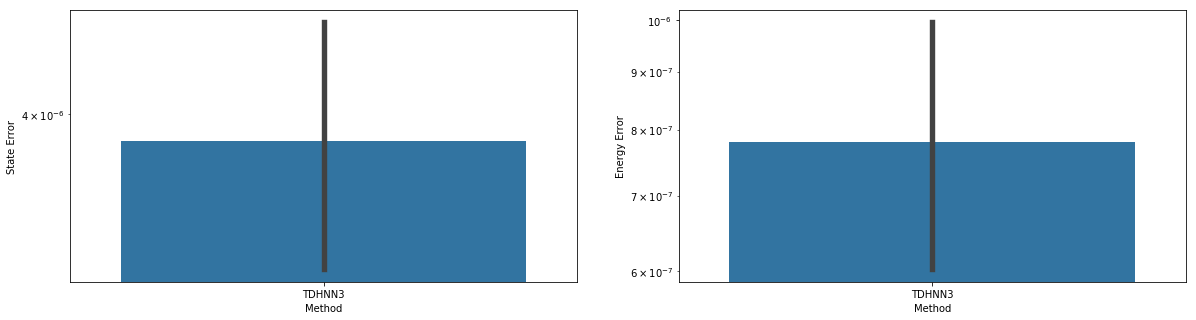

In [6]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
sns.set_context("poster")
g = sns.barplot(x='Method',y='State Error',data=new_df,ax=ax[0])
g.set_yscale('log')

g = sns.barplot(x='Method',y='Energy Error',data=new_df,ax=ax[1])
g.set_yscale('log')

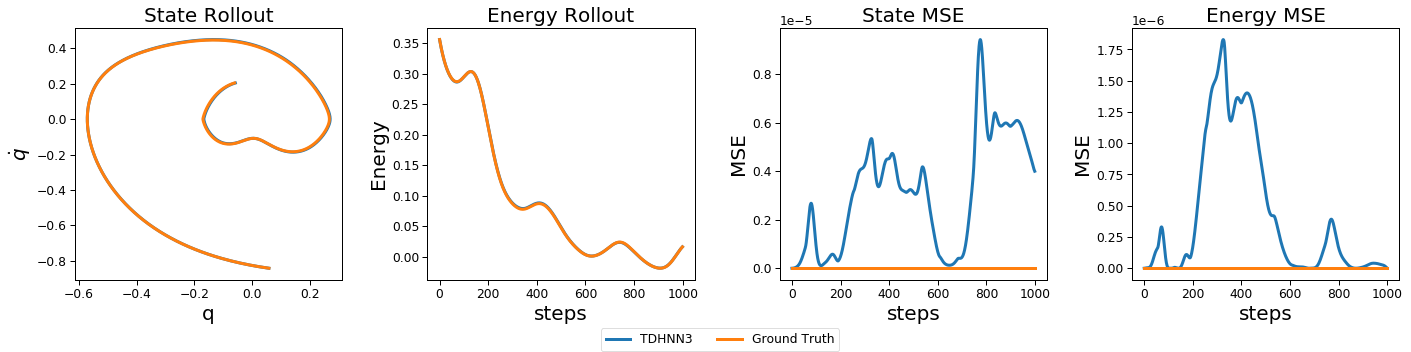

In [7]:
sns.axes_style(style='ticks')
sns.set_context("paper",font_scale=1.4, rc={'figure.figsize':(5,5),"font.size":20,"axes.titlesize":20,"axes.labelsize":20,'lines.linewidth':3})

lab_list = list(model_dct.keys())
fig,axs = plt.subplots(1,4,figsize=(5*4,5))
ax = axs.ravel()
#ax = axs.ravel()
# lab_list.remove('TDHNN')
# lab_list.remove('TDHNN2')
for dex,name in enumerate(lab_list):
    yhat = main_pred[name][-6][0][:-1]#main_pred_coll[dex]
    true_batch = main_pred[name][-6][1]
                    
    K_pred = hamiltonian_fn(yhat)
    K_true = hamiltonian_fn(true_batch)
    ham_pred = K_pred 
    ham_true = K_true 
    
    ax[0].set_title('State Rollout')
    sns.lineplot(x=yhat[::,0],y=yhat[::,1],label=lab_list[dex],sort=False,ax=ax[0],legend=False)
    #ax[0].scatter(input_batch[:,0],input_batch[:,1])
    ax[0].set_xlabel('q')
    ax[0].set_ylabel(r'$\dot{q}$')


    ax[1].set_title('Energy Rollout')
    sns.lineplot(x=range(len(ham_pred)),y=ham_pred,label=lab_list[dex],ax=ax[1],legend=False)
    ax[1].set_xlabel('steps')
    ax[1].set_ylabel('Energy')



    ax[2].set_title('State MSE')
    l1 =sns.lineplot(x=range(len(yhat)),y=((yhat-true_batch)**2).mean(1),label=lab_list[dex],ax=ax[2],legend=False)
    ax[2].set_xlabel('steps')
    ax[2].set_ylabel('MSE')

    ax[3].set_title('Energy MSE')
    l2 =sns.lineplot(x=range(len(yhat)),y=(ham_pred-ham_true)**2,label=lab_list[dex],ax=ax[3],legend=False)
    ax[3].set_xlabel('steps')
    ax[3].set_ylabel('MSE')
    
sns.lineplot(x=true_batch[:,0],y=true_batch[:,1],markers='x',label='Ground Truth',ax=ax[0],sort=False,legend=False)
sns.lineplot(x=range(len(ham_pred)),y=ham_true,label='Ground Truth',ax=ax[1],legend=False)
sns.lineplot(x=range(len(yhat)),y=np.zeros(len(yhat)),label='Ground Truth',ax=ax[2],legend=False)
sns.lineplot(x=range(len(yhat)),y=np.zeros(len(yhat)),label='Ground Truth',ax=ax[3],legend=False)
ax[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax[3].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax[1].set_yscale('log')
# ax[2].set_yscale('log')
handles, labels = ax[3].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',bbox_to_anchor=(0.5, -0.015),fancybox=True,ncol=6)
#plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('mass_spring_long.pdf',dpi=2400,bbox_inches='tight')


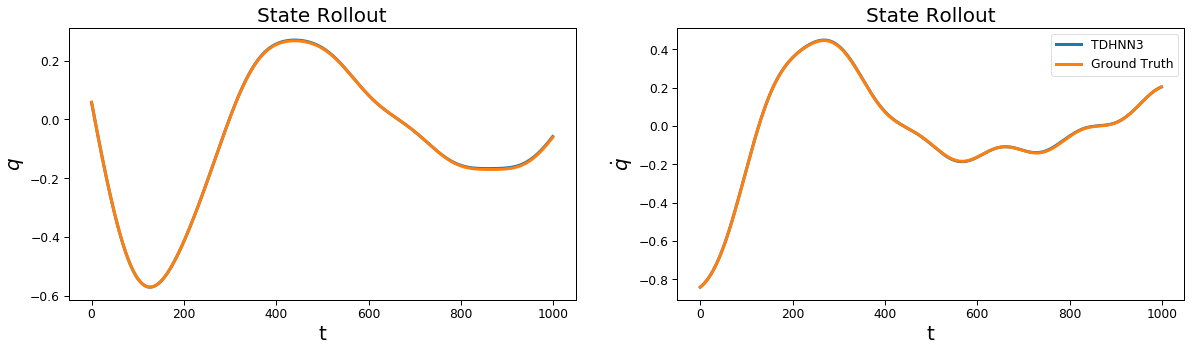

In [8]:
sns.axes_style(style='ticks')
sns.set_context("paper",font_scale=1.4, rc={'figure.figsize':(5,5),"font.size":20,"axes.titlesize":20,"axes.labelsize":20,'lines.linewidth':3})

lab_list = list(model_dct.keys())
fig,axs = plt.subplots(1,2,figsize=(5*4,5))
ax = axs.ravel()
#ax = axs.ravel()
# lab_list.remove('HNN')
# lab_list.remove('TDHNN')
# lab_list.remove('TDHNN1')
for dex,name in enumerate(lab_list):
    yhat = main_pred[name][-6][0][:-1]#main_pred_coll[dex]
    true_batch = main_pred[name][-6][1]
                    
    ax[0].set_title('State Rollout')
    sns.lineplot(x=range(len(yhat)),y=yhat[::,0],label=lab_list[dex],sort=False,ax=ax[0],legend=False)
    
    #ax[0].scatter(input_batch[:,0],input_batch[:,1])
    ax[0].set_xlabel('t')
    ax[0].set_ylabel(r'$q$')
    
    ax[1].set_title('State Rollout')
    sns.lineplot(x=range(len(yhat)),y=yhat[::,1],label=lab_list[dex],sort=False,ax=ax[1],legend=False)
    
    #ax[0].scatter(input_batch[:,0],input_batch[:,1])
    ax[1].set_xlabel('t')
    ax[1].set_ylabel(r'$\dot{q}$')

sns.lineplot(x=range(len(yhat)),y=true_batch[:,0],markers='x',label='Ground Truth',ax=ax[0],sort=False,legend=False)
sns.lineplot(x=range(len(yhat)),y=true_batch[:,1],markers='x',label='Ground Truth',ax=ax[1],sort=False,legend=False)
plt.legend()


In [9]:
model_type

TDHNN3(
  (mlp1): Linear(in_features=2, out_features=200, bias=True)
  (mlp2): Linear(in_features=200, out_features=200, bias=True)
  (mlp3): Linear(in_features=200, out_features=200, bias=True)
  (mlp4): Linear(in_features=200, out_features=1, bias=False)
  (f1): Linear(in_features=1, out_features=200, bias=True)
  (f2): Linear(in_features=200, out_features=200, bias=True)
  (f2_): Linear(in_features=200, out_features=200, bias=True)
  (f3): Linear(in_features=200, out_features=1, bias=False)
  (d1): Linear(in_features=1, out_features=1, bias=False)
)

In [10]:
for name, param in model_type.named_parameters():
    if param.requires_grad:
        print (name, param.data)

mlp1.weight tensor([[-1.0741e-01,  2.6534e-02],
        [ 7.8728e-02,  5.2511e-03],
        [ 1.9827e-02, -8.5258e-02],
        [-1.4740e-01, -1.2781e-01],
        [ 1.4940e-01, -1.1996e-01],
        [-5.2060e-02,  1.3818e-01],
        [-5.6848e-02,  8.1233e-02],
        [ 1.2370e-01, -9.2589e-02],
        [ 3.8203e-02, -1.2337e-03],
        [ 1.9620e-02, -7.6791e-02],
        [ 3.1641e-02, -1.6127e-02],
        [ 1.5837e-01, -1.8240e-02],
        [ 9.1620e-02,  3.9022e-02],
        [ 7.8249e-02,  1.4312e-01],
        [ 4.3458e-02,  6.5884e-02],
        [ 6.2755e-02, -1.1866e-02],
        [-6.7855e-02,  8.4886e-02],
        [-1.2918e-01,  4.8855e-02],
        [ 9.1713e-02,  1.2826e-01],
        [ 1.1288e-02,  6.0298e-02],
        [ 6.6404e-02, -1.0105e-01],
        [-8.8137e-02,  1.3186e-01],
        [-1.3630e-01, -6.9666e-02],
        [-1.6701e-01,  8.6357e-02],
        [ 5.1287e-02, -3.2251e-02],
        [ 7.0630e-02, -1.5335e-01],
        [-5.4016e-02, -1.2973e-01],
        [-1.5431

In [13]:
torch.sigmoid(torch.tensor(1.52))


tensor(0.8205)

In [14]:
torch.sigmoid(torch.tensor(0.056))

tensor(0.5140)

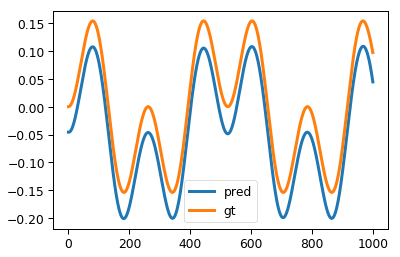

In [9]:
tevals = torch.arange(0,10.01,0.01)
tevals.to(device)
tevals.requires_grad = True
tevals = tevals.float()
f = model_type.get_F(tevals.reshape(-1,1))
plt.plot(-f.detach().numpy(),label='pred')
plt.plot(0.2*np.sin(1.2*tevals.detach().numpy())*np.sin(2.4*tevals.detach().numpy()),label='gt')
plt.legend()

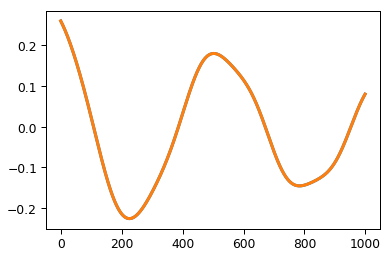

In [11]:
for batch_i, (q, q_next, energy_, qdx, tevals) in enumerate(data_dict['valid']):
    q=q.to(device)
    q=q.float()
    q.requires_grad=True
    tevals.to(device)
    tevals.requires_grad = True
    tevals = tevals.float()
    f = model_type.get_D(q[:,1].reshape(-1,1))
    plt.plot(-f.detach().numpy(),label='pred')
    plt.plot(0.3*q[:,1].detach().numpy(),label='gt')
    break

In [11]:
q = torch.arange(-5,5,0.1)
qd = torch.arange(-5,5,0.1)
q= q.float()
qd = qd.float()
q.requires_grad = True
qd.requires_grad = True
qvec = torch.cat([q.reshape(-1,1),qd.reshape(-1,1)],1)
f = model_type.get_H(qvec)


In [12]:
qm,qdm = torch.meshgrid(q,qd)

In [13]:
f = model_type.get_H(torch.cat([qm.reshape(-1,1),qdm.reshape(-1,1)],1))

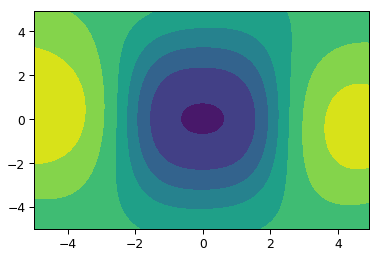

In [14]:
plt.contourf(qm.detach().numpy(),qdm.detach().numpy(),f.reshape(-1,qm.shape[0]).detach().numpy())

In [47]:

model_type.f3.weight

Parameter containing:
tensor([[-2.8749e-02, -3.5966e-02,  6.8856e-02,  5.3383e-02,  4.3093e-02,
         -5.4524e-02, -1.0189e-02, -1.4727e-02,  7.1466e-02, -4.2445e-02,
         -4.4129e-02,  1.0007e-01,  4.1829e-02, -1.1200e-01, -3.0512e-02,
          8.2839e-02,  1.3796e-01, -8.6580e-02,  9.0889e-03,  6.0140e-02,
         -3.4457e-02, -5.2510e-04,  5.2127e-04, -7.8671e-03,  6.1372e-02,
          1.0587e-03, -1.0371e-01, -9.7648e-02,  8.9857e-02, -2.5417e-03,
          1.3451e-01,  1.5510e-02, -1.7066e-02,  6.9484e-02,  2.9604e-02,
         -1.3987e-02,  3.1895e-02,  1.1272e-01, -2.5302e-02,  4.0529e-02,
         -1.1893e-01, -4.2077e-02, -1.1450e-01,  1.6553e-01,  1.2852e-01,
          2.1697e-01, -5.6715e-02, -1.4004e-01,  2.9060e-02, -8.8631e-02,
          3.2727e-02, -2.1741e-03,  9.1915e-02,  6.5766e-03, -8.8785e-04,
          6.5643e-04, -6.3300e-02,  1.2166e-02, -5.3498e-02,  6.5754e-04,
         -1.5640e-02, -4.0288e-03, -3.3099e-02,  3.3492e-02,  1.9404e-04,
          1.0777